# Введение в анализ данных
## НИУ ВШЭ, 2020-2021 учебный год

### Домашнее задание №8

In [8]:
import numpy as np
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, mean_squared_error

## Градиентный бустинг своими руками (2 + 2* баллов)

Реализуйте алгоритм градиентного бустинга для регрессии. Напомним основные формулы.

Обозначим текущую композицию на $N-1$ шаге за $a_{N - 1}(x_i)$. Следующий базовый алгоритм $b_N(x_i)$ обучается на ответах $-\frac{\partial L(y_i, z)}{\partial z}\Bigl|_{z = a_{N - 1}(x_i)}$, где $L(y_i, z)$ — значение функции потерь на объекте при правильном ответе $y_i$ и предсказании $z$. Композиция на следующем шаге получается следующим образом:

$$
a_N(x_i) = a_{N-1}(x_i) + \nu\gamma_Nb_N(x_i)
$$

Здесь $\nu$ — гиперпараметр learning rate, $\gamma_N$ — оптимальный вес, настраиваемый на каждом шаге алгоритма, который можно найти по следующей формуле (обратите внимание на отсутствие $\nu$):

$$
\gamma_N = \mathrm{arg}\min_\gamma \frac{1}{\ell}\sum\limits_{i=1}^{\ell}L\left(y_i, a_{N - 1}(x_i) + \gamma b_N(x_i)\right)
$$

Можете принять $\gamma_N = 1$ для каждого $N$. Реализуйте нахождение оптимального $\gamma_N$ на каждом шаге, чтобы получить ещё 1 балл.

В качестве функции потерь возьмите MSE.

*Примечание. Вы можете использовать `DecisionTree` из `sklearn` и методы оптимизации из различных библиотек.*

In [142]:
# это может помочь вам для поиска оптимальных gamma
from scipy.optimize import minimize
from sklearn.model_selection import GridSearchCV

In [81]:
? minimize

In [82]:
class GradientBoosting:
    def __init__(self, n_estimators, max_depth, learning_rate=0.1):
        """
        PARAMETERS:
        n_estimators - number of trees in the ensemble
        max_depth - maximum depth of a tree
        learning_rate - coefficient by which new algorithm result is multiplied
        """
        # your code here
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        self.gamma = 1
        
    def fit(self, x, y):
        """
        INPUT:
        x - np.array of shape (k, d)
        y - np.array of shape (k,)
        """
        # Здесь нам нужно проитерироваться по n_estimators и обучить
        # соответствующее количество деревьев с помощью _fit_predict_tree(),
        # правильно обновляя y_new
        # Деревья нужно где-то сохранить, чтобы затем использовать в predict()

        self.trees = []
        y_new = 0
        for _ in range(self.n_estimators):
            s1 = y - y_new
            y_new +=  self._fit_predict_tree(x, s1)

    def _fit_predict_tree(self, x, y):
        # Обучаем дерево и возвращаем его предикшн
        
        tree = DecisionTreeRegressor(max_depth = self.max_depth)
        tree.fit(x, y)
        self.trees.append(tree)
        
        return self.gamma * self.learning_rate * tree.predict(x)
        
    def predict(self, x):
        """
        INPUT:
        x - np.array of shape (m, d)
        OUTPUT:
        y_pred - np.array of shape (m,)
        """
        # Используем сохранённые деревья для расчёта агрегированного предикшна
        # your code here
        
        y_pred = 0
        for i in self.trees:
            y_pred += self.learning_rate * i.predict(x)
        
        return y_pred

Проверьте вашу реализацию на Boston dataset. Подберите оптимальные гиперпараметры, чтобы победить RandomForestRegressor как в обычном случае, так и при нахождении оптимального шага **(не меняйте параметры сида)**. При необходимости воспользуйтесь GridSearch. За это вы получите ещё 1 балл.

In [121]:
boston = load_boston()
X = boston.data
y = boston.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=13)

In [280]:
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(max_features=1, n_estimators=500, random_state=19052019)

rf.fit(X_train, y_train)
mean_squared_error(y_test, rf.predict(X_test))

14.621249425826786

In [285]:
np.random.seed(19052019)

gb = GradientBoosting(n_estimators=500, max_depth=3, learning_rate=0.008)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
mean_squared_error(y_test, y_pred)

11.379704611333155

Реализация гаммы. 

In [138]:
class GradientBoosting:
    def __init__(self, n_estimators, max_depth, learning_rate=0.1):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.learning_rate = learning_rate
        
    def fit(self, x, y):
        self.trees = []
        self.y = y
        self.y_new = 0
        self.gammas = []
        for _ in range(self.n_estimators):
            s1 = y - self.y_new
            self.y_new +=  self._fit_predict_tree(x, s1)

    def _fit_predict_tree(self, x, y):
        
        tree = DecisionTreeRegressor(max_depth = self.max_depth)
        tree.fit(x, y)
        y_pred = tree.predict(x)
        self.trees.append(tree)
        fun = lambda x: mean_squared_error(self.y, (x*y_pred + self.y_new))
        res = minimize(fun, x0=1)
        gamma = float(res['x'])
        self.gammas.append(gamma)
        
        return gamma * self.learning_rate * y_pred
        
    def predict(self, x):
        y_pred = 0
        for i in range(len(self.trees)):
            y_pred += self.learning_rate * self.trees[i].predict(x) * self.gammas[i]
        
        return y_pred

In [141]:
np.random.seed(19052019)

gb = GradientBoosting(n_estimators=10000, max_depth=3, learning_rate=0.008)
gb.fit(X_train, y_train)
y_pred = gb.predict(X_test)
mean_squared_error(y_test, y_pred)

11.34043646366957

Для удобства проверяющего укажите, пожалуйста, реализовали ли вы нахождение оптимального шага?

- Да

## Прогнозируем задержки самолётов (2 балла)

Поработаем с задачей про задержки самолётов. На основании доступных данных о рейсе вам нужно определить, будет ли он задержан на 15 минут.
Воспользуйтесь любыми методами градиентного бустинга {XGboost, catboost, LightGBM} и GridSearch для достижения результата. Получите 1 балл за преодоление порога roc_auc_score 0.72 и ещё 1 балл за преодоление порога 0.74.

In [3]:
import pandas as pd

In [59]:
train = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering/flight_delays_train.csv')
test = pd.read_csv('https://raw.githubusercontent.com/PersDep/data-mining-intro-2021/main/hw08-boosting-clustering/flight_delays_test.csv')

In [5]:
train.head()

,Month,DayofMonth,DayOfWeek,DepTime,UniqueCarrier,Origin,Dest,Distance,dep_delayed_15min
0,c-8,c-21,c-7,1934,AA,ATL,DFW,732,N
1,c-4,c-20,c-3,1548,US,PIT,MCO,834,N
2,c-9,c-2,c-5,1422,XE,RDU,CLE,416,N
3,c-11,c-25,c-6,1015,OO,DEN,MEM,872,N
4,c-10,c-7,c-6,1828,WN,MDW,OMA,423,Y


In [10]:
import warnings
warnings.filterwarnings("ignore")

In [35]:
# Референс

from xgboost.sklearn import XGBClassifier

X_train = train[['Distance', 'DepTime']].values
y_train = train['dep_delayed_15min'].map({'Y': 1, 'N': 0}).values
X_test = test[['Distance', 'DepTime']].values
X_train_part, X_valid, y_train_part, y_valid = train_test_split(X_train, y_train, test_size=0.3)

xgb_model = XGBClassifier()
xgb_model.fit(X_train_part, y_train_part)
roc_auc_score(y_valid, xgb_model.predict_proba(X_valid)[:, 1])

[21:42:52] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


0.7004442585202582

In [50]:
import catboost
from catboost import *
from catboost import CatBoostClassifier

In [45]:
y = train['dep_delayed_15min']
X = train.drop('dep_delayed_15min', axis=1)

In [46]:
cat_features = list(range(0, X.shape[1]))
print(cat_features)

[0, 1, 2, 3, 4, 5, 6, 7]


In [49]:
pool1 = Pool(data=X, label=y, cat_features=cat_features)

pool2 = Pool(data=X, cat_features=cat_features)

X_prepared = X.values.astype(str).astype(object)

pool3 = Pool(
    data=FeaturesData(
        cat_feature_data=X_prepared,
        cat_feature_names=list(X)
    ),
    label=y.values
)

In [51]:
X_train, X_validation, y_train, y_validation = train_test_split(X, y, train_size=0.8, random_state=42)

In [55]:
model = CatBoostClassifier(
    #iterations=5,
    #learning_rate=0.1,
    # loss_function='CrossEntropy'
)
model.fit(
    X_train, y_train,
    cat_features=cat_features,
    eval_set=(X_validation, y_validation),
    verbose=False
)
print('Model is fitted: ' + str(model.is_fitted()))
print('Model params:')
print(model.get_params())

Model is fitted: True
Model params:
{}


In [56]:
roc_auc_score(y_validation, model.predict_proba(X_validation)[:, 1])

0.7607594605003798

Порог преодален. roc_auc = 0.76076. 

## DBSCAN своими руками (2 + 2* баллов)

DBSCAN: Density-based spatial clustering of applications with noise

Реализуйте класс dbscan.

Алгоритм имеет два основных гиперпараметра:
1. `eps` &mdash; радиус рассматриваемой окрестности
2. `min_samples` &mdash; число соседей в окрестности

Для выполнения кластеризации DBSCAN точки делятся на основные точки, достижимые по плотности точки и выпадающие следующим образом:

- Точка $p$ является основной точкой, если по меньшей мере `min_samples` точек находятся на расстоянии, не превосходящем 
`eps` от неё. Говорят, что эти точки достижимы прямо из $p$.

-  Точка $q$ прямо достижима из $p$, если точка $q$ находится на расстоянии, не большем `eps`, от точки $p$, и $p$ — основная точка.
Точка $q$ достижима из $p$, если имеется путь 
$p_1,…,p_n$ где $p_1=p$ и $p_n=q$ , а каждая точка $p_{i+1}$ достижима прямо из $p_i$ (все точки на пути должны быть основными, за исключением $q$).

Все точки, не достижимые из основных точек, считаются выбросами.

Теперь, если $p$ является основной точкой, то она формирует кластер вместе со всеми точками (основными или неосновными), достижимыми из этой точки. Каждый кластер содержит по меньшей мере одну основную точку. Неосновные точки могут быть частью кластера, но они формируют его «край», поскольку не могут быть использованы для достижения других точек.


In [67]:
# Это может помочь вам для поиска дистанции между точками
from scipy.spatial import distance

In [68]:
class dbscan:
    def __init__(self, eps, min_samples):
        self.eps = eps
        self.min_samples = min_samples
        
    def fit_predict(self, X):
        self.X = X
        self.cluster_id = 1
        self.points = self.X.shape[0]
        self.classification = ['UNCLASS'] * self.points
        for i in range(self.points):
            if self.classification[i] == 'UNCLASS':
                neighbours = self.range_query(self.X[i])
                if len(neighbours) < self.min_samples:
                    self.classification[i] = 0
                else:
                    if self.grow_cluster(i, neighbours):
                        self.cluster_id = self.cluster_id + 1
        
        return self.classification           


    def grow_cluster(self, root, neighbours):
        self.classification[root] = self.cluster_id
        for neig_id in neighbours:
            self.classification[neig_id] = self.cluster_id
            
        while len(neighbours) > 0:
            current = neighbours[0]
            results = self.range_query(self.X[current])
            if len(results) >= self.min_samples:
                for r in results:
                    if (self.classification[r] == 'UNCLASS') or (self.classification[r] == 'NOISE'):
                        if self.classification[r] == 'UNCLASS':
                            neighbours.append(r)
                        self.classification[r] = self.cluster_id
            neighbours = neighbours[1:]
        return True 
        
    def range_query(self, x):
        neighbours = []
        for i in range(self.points):
            if distance.euclidean(x, self.X[i]) < self.eps:
                neighbours.append(i)
        return neighbours


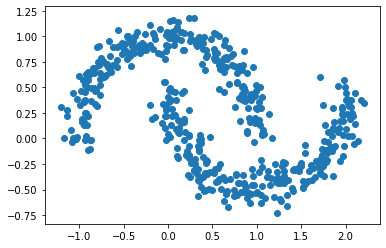

In [69]:
from sklearn.datasets import make_moons
import matplotlib.pyplot as plt
import pandas as pd

X, _ = make_moons(n_samples=500, noise=0.1)
plt.scatter(X[:,0], X[:,1])
plt.show()

Кластеризуйте это с помощью своей версии DBSCAN:

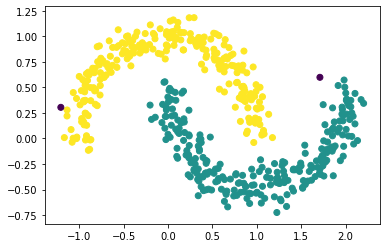

In [70]:
# your code here
clusters = dbscan(eps=0.19, min_samples=10).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

Референс:

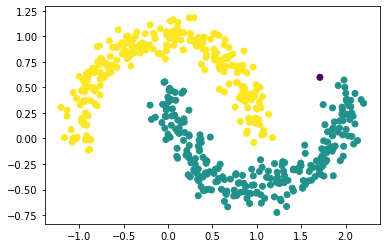

In [71]:
from sklearn.cluster import DBSCAN

clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

plt.scatter(X[:,0], X[:,1], c=clusters)
plt.show()

Получите 1 балл за ещё один интересный пример кластеризации (в качестве референса используйте предоставленное изображение. Нужно несколько интересных соседствующих форм):

In [72]:
# your code here

Или хотя бы что-нибудь такое: 

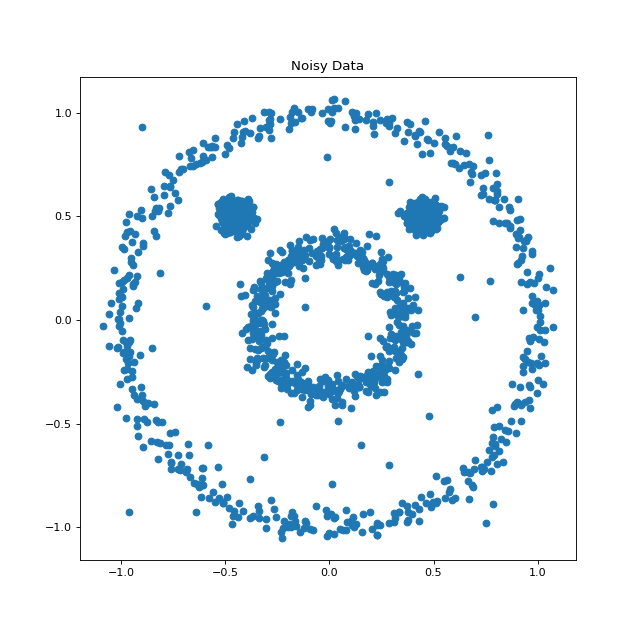

In [73]:
# your code here
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs, make_circles, make_moons, make_s_curve

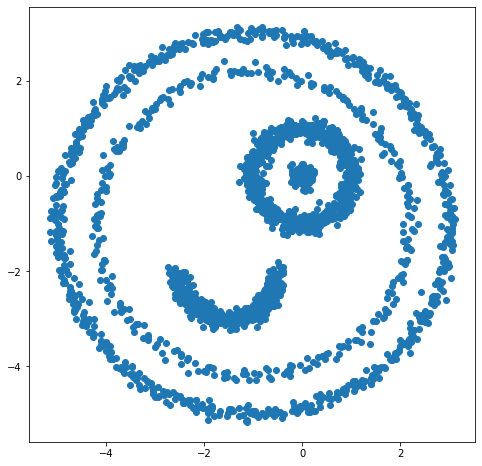

In [74]:
A, _ = make_circles(n_samples=(700,100), factor=0.1, noise=0.1)
Y, _ = make_moons(n_samples=(0,500), noise=0.1)
Z = np.concatenate((A, Y-2.5), axis=0)

M, _ = make_circles(n_samples=(700,300), factor=0.8, noise=0.02)
Z = np.concatenate((Z, M*4 - 1), axis=0)
plt.figure(figsize=(8,8))
plt.scatter(Z[:,0], Z[:,1])
plt.show()

Это одноглазый смайлик, выглядит ужасно

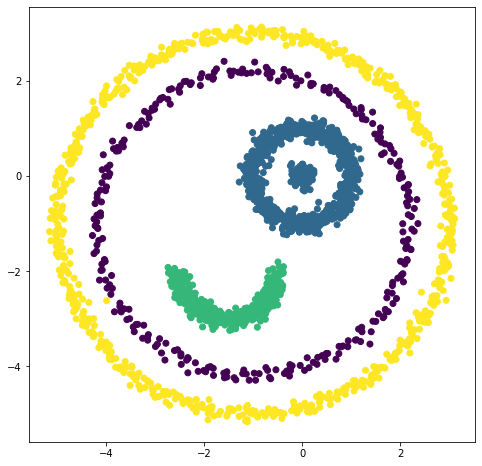

In [77]:
clusters = dbscan(eps=0.37, min_samples=15).fit_predict(Z)
plt.figure(figsize=(8,8))
plt.scatter(Z[:,0], Z[:,1], c=clusters)
plt.show()

Получите ещё 1 балл, если время работы вашего алгоритма больше референсного не более чем в 100 раз с учётом погрешности 3% от вашего времени:

In [210]:
%%time
%%capture
clusters = DBSCAN(eps=0.2, min_samples=10).fit_predict(X)

CPU times: user 11.4 ms, sys: 2.72 ms, total: 14.1 ms
Wall time: 12.3 ms


In [211]:
%%time
%%capture
clusters = dbscan(eps=0.2, min_samples=10).fit_predict(X)

CPU times: user 3.91 s, sys: 16.9 ms, total: 3.93 s
Wall time: 3.96 s
